In [1]:
BASE_DIR  = r"E:\AIML"
DATA_PATH = rf"E:\AIML\dataset\heart_attack_prediction_dataset.csv"
EDA_DIR   = rf"E:\AIML\results\eda_visualizations"
OUT_DIR   = rf"E:\AIML\results\outputs"

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA

try:
    from imblearn.over_sampling import SMOTE
except Exception:
    SMOTE = None  # Only needed for Member F

warnings.filterwarnings("ignore")
os.makedirs(EDA_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

TARGET = "Heart Attack Risk"
RANDOM_STATE = 42

In [2]:
df = pd.read_csv(DATA_PATH)
assert TARGET in df.columns, f"TARGET '{TARGET}' not found. Columns: {list(df.columns)}"

id_like = {"patient id","id","record id"}
drop_ids = [c for c in df.columns if c.strip().lower() in id_like]
if drop_ids:
    df = df.drop(columns=drop_ids)

X = df.drop(columns=[TARGET]).copy()
y = df[TARGET].values
strat = y if pd.Series(y).nunique() <= 20 else None

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=strat
)
print("Train/Test:", X_train.shape, X_test.shape)

Train/Test: (7010, 24) (1753, 24)


In [3]:
# --- Detect categorical vs numeric ---
LOW_CARD_AS_CAT = 12
categorical_cols = []
for c in X_train.columns:
    if X_train[c].dtype == "object":
        categorical_cols.append(c)
    else:
        if X_train[c].nunique(dropna=True) <= LOW_CARD_AS_CAT:
            categorical_cols.append(c)
numeric_cols = [c for c in X_train.select_dtypes(include="number").columns if c not in categorical_cols]
print("Categorical:", categorical_cols)
print("Numeric:", numeric_cols)
#%%


Categorical: ['Sex', 'Blood Pressure', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country', 'Continent', 'Hemisphere']
Numeric: ['Age', 'Cholesterol', 'Heart Rate', 'Exercise Hours Per Week', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides']


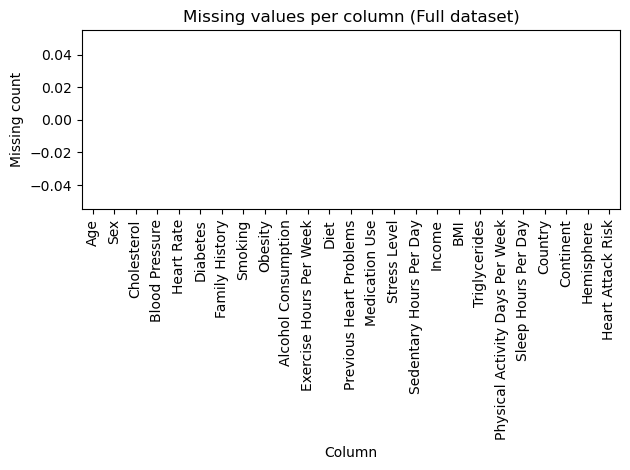

In [4]:
# --- A1: Missingness visualization ---
na_counts = df.isna().sum().sort_values(ascending=False)
plt.figure()
(na_counts[na_counts>0] if na_counts.max()>0 else na_counts).plot(kind="bar")
plt.title("Missing values per column (Full dataset)"); plt.xlabel("Column"); plt.ylabel("Missing count")
plt.tight_layout(); plt.savefig(os.path.join(EDA_DIR, "missing_values_full.png")); plt.show()

In [5]:
# --- A2: Imputation (fit on TRAIN only) ---
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

X_train_num = num_imputer.fit_transform(X_train[numeric_cols]) if numeric_cols else None
X_test_num  = num_imputer.transform(X_test[numeric_cols])      if numeric_cols else None
X_train_cat = cat_imputer.fit_transform(X_train[categorical_cols]) if categorical_cols else None
X_test_cat  = cat_imputer.transform(X_test[categorical_cols])      if categorical_cols else None

tr_parts, te_parts = [], []
if X_train_num is not None:
    tr_parts.append(pd.DataFrame(X_train_num, columns=numeric_cols, index=X_train.index))
    te_parts.append(pd.DataFrame(X_test_num,  columns=numeric_cols, index=X_test.index))
if X_train_cat is not None:
    tr_parts.append(pd.DataFrame(X_train_cat, columns=categorical_cols, index=X_train.index))
    te_parts.append(pd.DataFrame(X_test_cat,  columns=categorical_cols, index=X_test.index))

X_train_imp = pd.concat(tr_parts, axis=1) if tr_parts else pd.DataFrame(index=X_train.index)
X_test_imp  = pd.concat(te_parts, axis=1) if te_parts else pd.DataFrame(index=X_test.index)

print("After imputation -> TRAIN:", X_train_imp.shape, " TEST:", X_test_imp.shape)
print("Remaining NaNs (TRAIN, TEST):",
      int(X_train_imp.isna().sum().sum()), int(X_test_imp.isna().sum().sum()))
#%%


After imputation -> TRAIN: (7010, 24)  TEST: (1753, 24)
Remaining NaNs (TRAIN, TEST): 0 0


In [6]:
# --- A3: Save outputs ---
pd.concat([X_train_imp, pd.Series(y_train, index=X_train_imp.index, name=TARGET)], axis=1)\
  .to_csv(os.path.join(OUT_DIR, "X_train_imputed.csv"), index=False)
pd.concat([X_test_imp,  pd.Series(y_test,  index=X_test_imp.index,  name=TARGET)], axis=1)\
  .to_csv(os.path.join(OUT_DIR, "X_test_imputed.csv"),  index=False)
print("Saved: X_train_imputed.csv, X_test_imputed.csv in outputs/")

Saved: X_train_imputed.csv, X_test_imputed.csv in outputs/
